#### Bu model için, çok bilinen bir binary classification problemi verisi üzerine odaklanmaktayız. Müşterilerin kredi kartı verilerini kullanarak, herhangi bir dolandırıcılık vakası olup olmadığının kontrolü gerçekleştirilecek.

#### Bu verinin en büyük eksiği, 0 ve 1 etiketli verinin dengesiz dağılımı ve bu sebeple tahmin algoritmalarının ciddi bir yanılgıya düşmesi durumu idi. Bunu aşabilmek adına, SMOTE algoritması ile dengesiz dağılımlı verinin zenginleştirilmesi işlemini uygulayacağız.

###### yapılan işlemlerin açıklaması:
PCA Dönüşümü: Verilerin açıklaması, tüm özelliklerin bir PCA dönüşümünden (Boyut Azaltma tekniği) geçtiğini belirtir (Zaman ve miktar hariç).

Scaling: Bir PCA dönüşümü uygulamak için özelliklerin önceden ölçeklendirilmesi gerekir.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import collections
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import ShuffleSplit, learning_curve, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy.stats import norm

import warnings

warnings.filterwarnings('ignore')

In [2]:
pd.set_option("display.max_rows", 999)

In [ ]:
df = pd.read_csv('creditcard.csv')
df.head()

In [4]:
len(df.query('Class != 1'))

284315

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


##### veride herhangi bir null veya NaN değer var mı kontrollerini yapmalıyız.

In [6]:
df.isnull().sum().max()

0

In [7]:
print(df.columns.tolist())

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [8]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


### Gördüğümüz üzere veride fraud verisi çok çok az. Gelecek işlemlerde bunun için veri zenginleştirmesi yapmak doğru bir yol olacaktır.

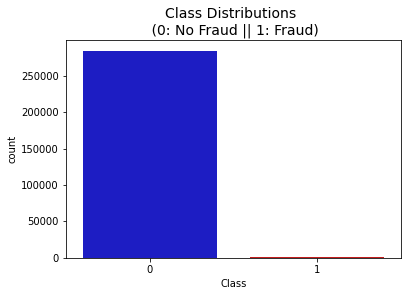

In [9]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

Dağılımları görerek bu özelliklerin ne kadar çarpık olduğu hakkında bir fikir sahibi olabiliriz, ayrıca diğer özelliklerin dağılımlarını da görebiliriz. Dağılımların daha az çarpık olmasına yardımcı olabilecek teknikler vardır ve bunlar gelecekte bu kodda uygulanacaktır.

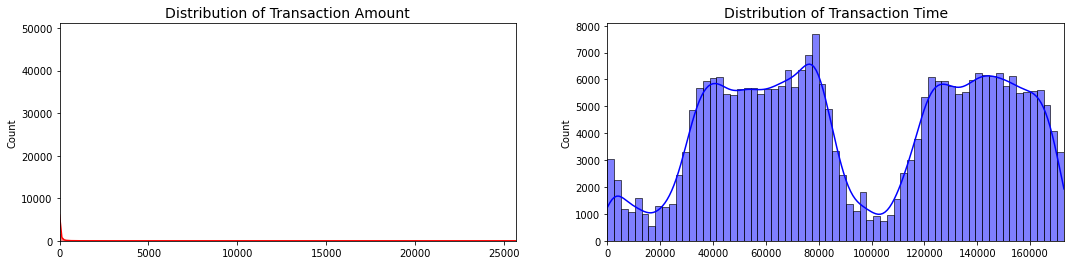

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.histplot(amount_val, ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.histplot(time_val, ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [11]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)

# RobustScaler is less prone to outliers.
#minmax_scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [12]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [13]:
# veriyi train ve test kısımları olarak ayıralım.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


Distribution of the Classes in the subsample dataset
Class
0    0.998273
1    0.001727
Name: count, dtype: float64


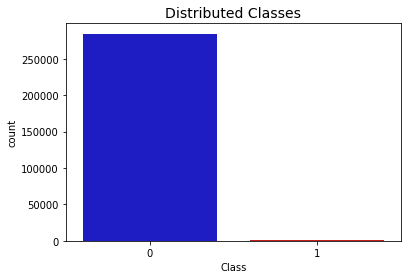

In [14]:
# normal way

non_fraud_df = df[df['Class'] == 0]
fraud_df = df[df['Class'] == 1]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts() / len(new_df))

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Distributed Classes', fontsize=14)
plt.show() # veri seti çok dengesiz iken model denemelerini gerçekleştirelim.

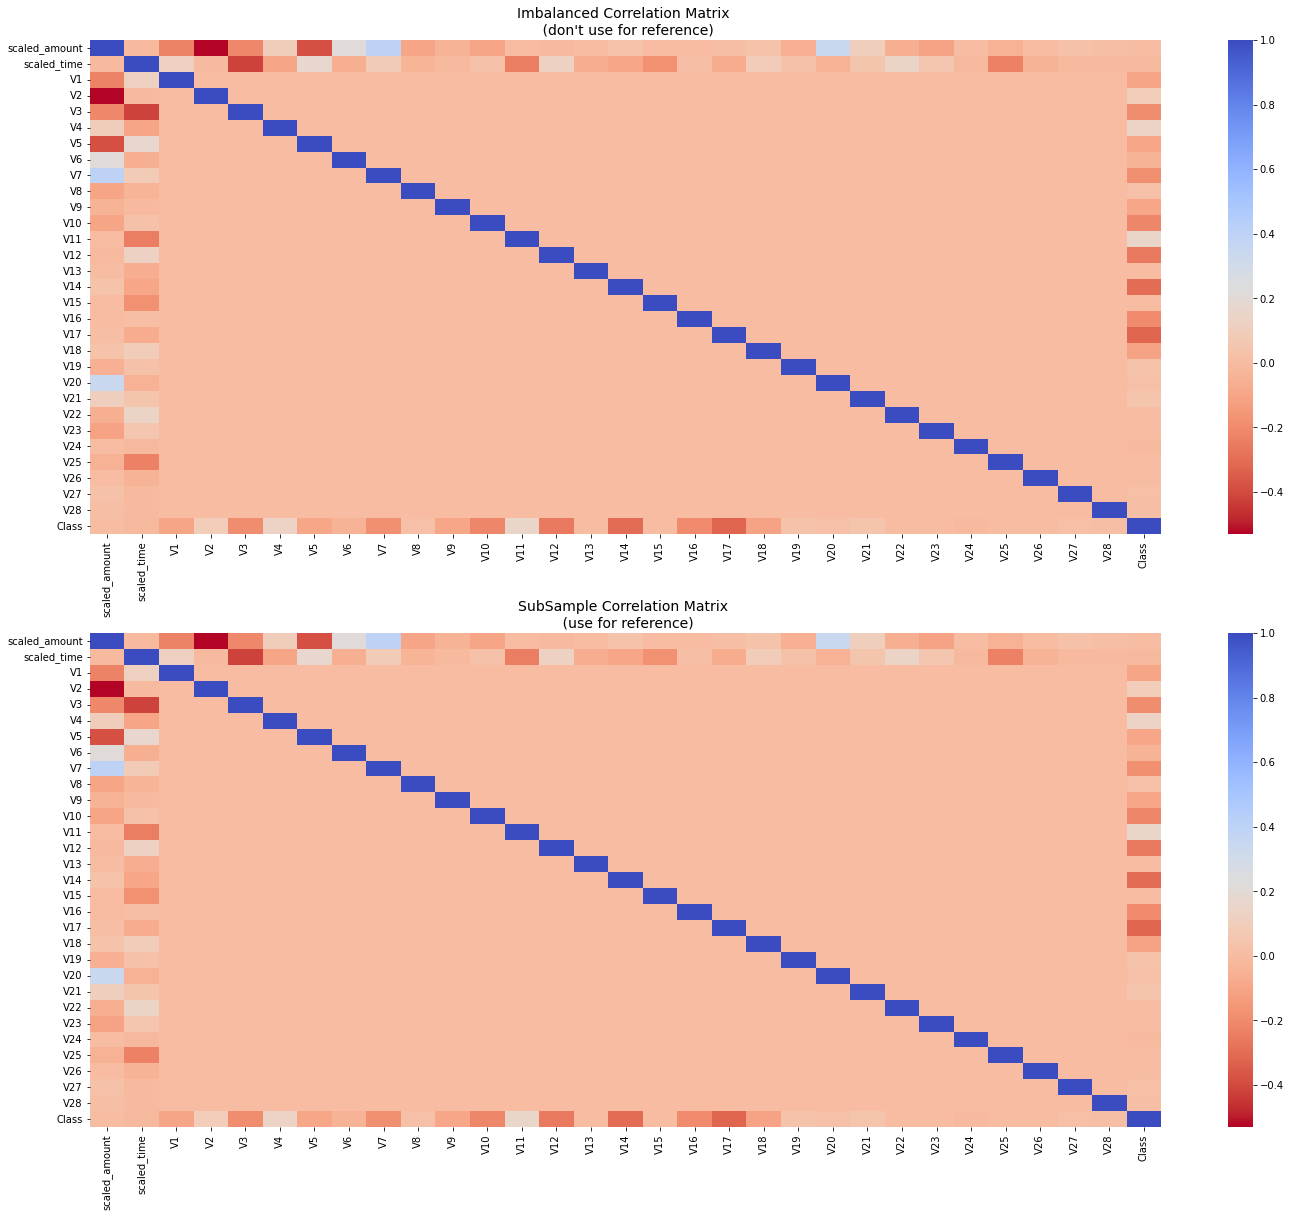

In [15]:
# Make sure we use the subsample in our correlation
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

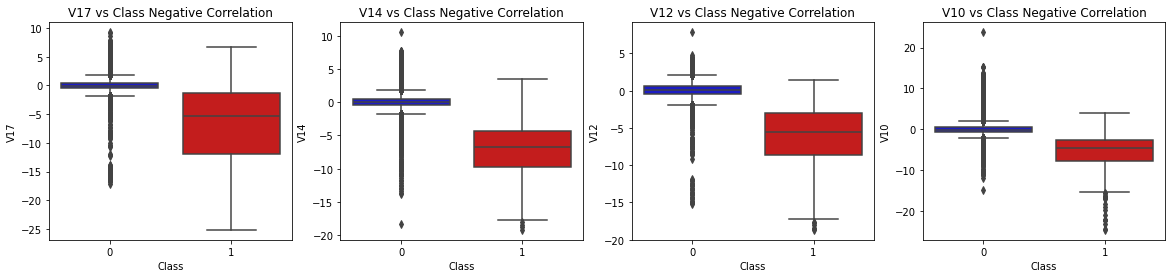

In [16]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

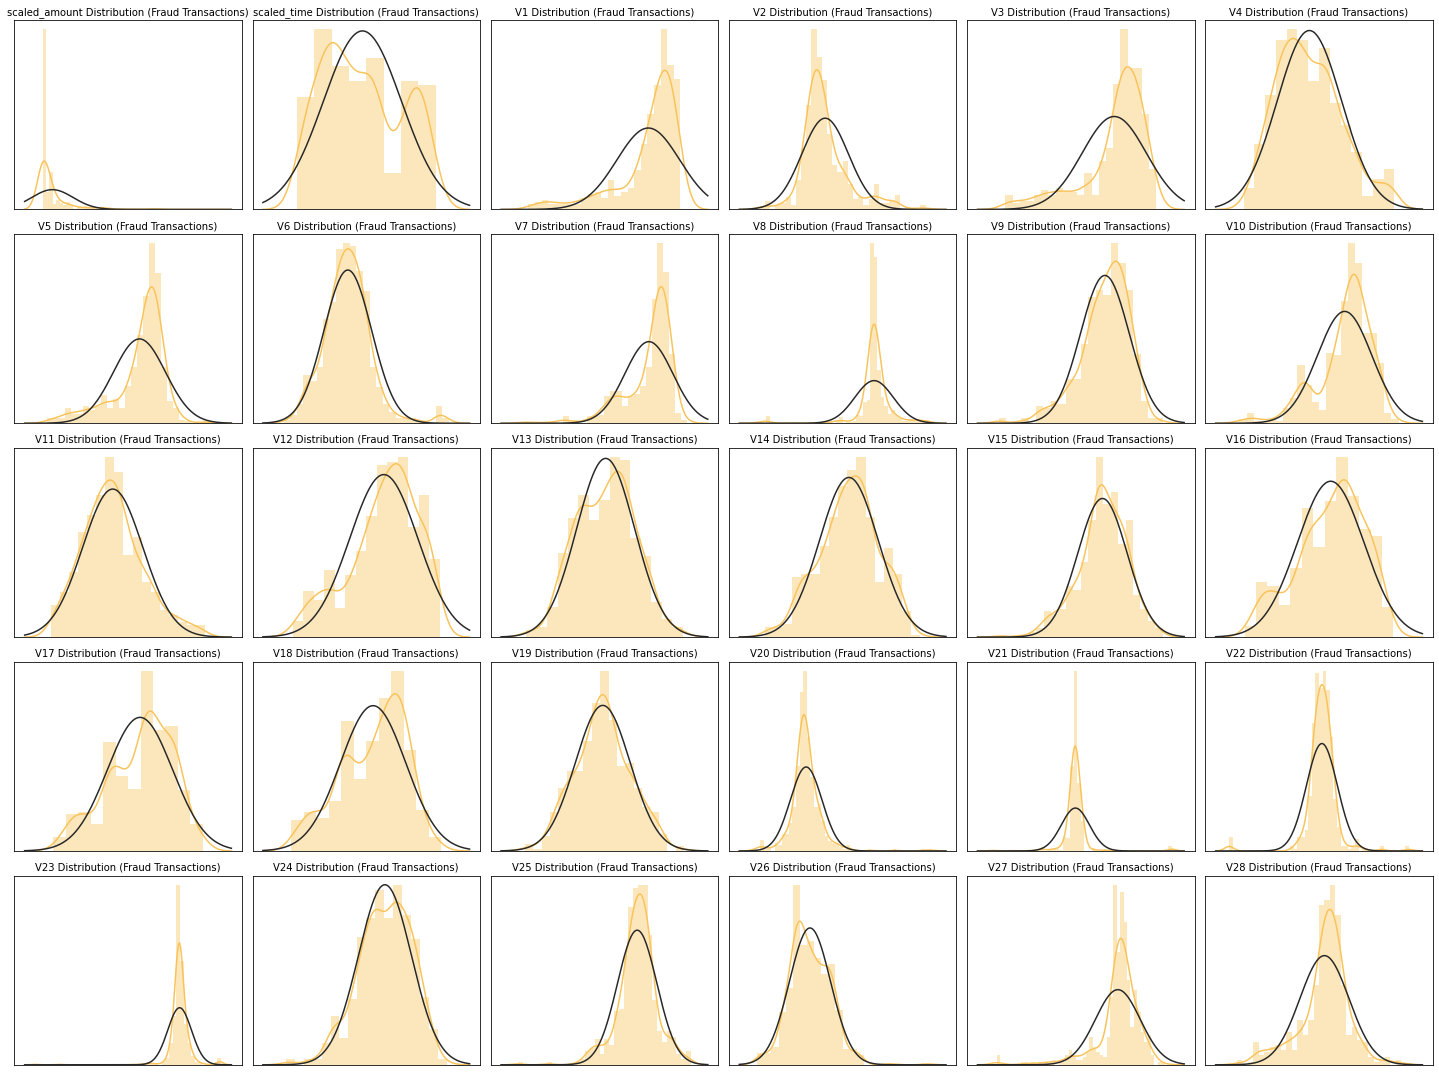

In [17]:
f, axs = plt.subplots(5, 6, figsize=(20, 15))
axs = axs.ravel()

for i, column in enumerate(new_df.columns[0:30]):  # 'V1' ile 'V28' arasındaki özellikler
    v_fraud_dist = new_df[column].loc[new_df['Class'] == 1].values
    sns.distplot(v_fraud_dist, ax=axs[i], fit=norm, color='#F9C35B')
    axs[i].set_title(f'{column} Distribution (Fraud Transactions)', fontsize=10)
    axs[i].set_yticks([])  # Y ekseni etiketlerini kapatır
    axs[i].set_xticks([])  # X ekseni etiketlerini kapatır
    axs[i].set_xlabel('')  # X ekseni etiketini kapatır
    axs[i].set_ylabel('')  # Y ekseni etiketini kapatır

plt.tight_layout()
plt.show()


In [18]:
# Kullanılacak özelliklerin listesi
features = new_df.columns[0:30]  # 'V1' ile 'V28' arası özellikler

for feature in features:
    fraud_values = new_df[feature].loc[new_df['Class'] == 1].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    
    print(f'{feature} Lower Bound: {lower_bound}')
    print(f'{feature} Upper Bound: {upper_bound}')
    
    outliers = [x for x in fraud_values if x < lower_bound or x > upper_bound]
    print(f'{feature} Outliers: {outliers}')
    print(f'Feature {feature} Outliers for Fraud Cases: {len(outliers)}')

    new_df = new_df.drop(new_df[(new_df[feature] > upper_bound) | (new_df[feature] < lower_bound)].index)
    print(f'Number of Instances after outliers removal for {feature}: {len(new_df)}')
    print('----' * 22)


scaled_amount Lower Bound: -2.4919304129113393
scaled_amount Upper Bound: 3.370711940194229
scaled_amount Outliers: [5.650806958708866, 24.97980856563963, 9.713547124991267, 3.4653811220568715, 8.747292670998393, 6.107315028295955, 9.798225389506044, 6.4098372109271295, 16.724516174107457, 3.7473625375532733, 29.39802976315238, 11.282191015161043, 8.567036959407533, 10.547474324041083, 6.850415706001537, 4.228184168238664, 4.643750436665968, 3.507440788094739, 3.5515964507790123, 4.4450499545867395, 18.34695731153497, 7.977363236218822, 4.108991825613079, 7.084468664850136, 4.152868022077831, 7.678054915112137, 19.10934115838748, 6.535457276601691, 4.137637113113953, 20.72144204569273, 4.042199399147628, 12.622231537762872, 13.613777684622372, 4.051002585062531, 5.142178439181164, 18.615943547823658, 4.57039055404178, 4.758611052888982, 3.8286872074338016, 15.021169566128695, 4.540487668553064, 8.555858310626702, 4.16418640396842, 5.998323202682876, 19.285404876685533, 9.86389995109341

Distribution of the Classes in the subsample dataset
Class
0    0.999036
1    0.000964
Name: count, dtype: float64


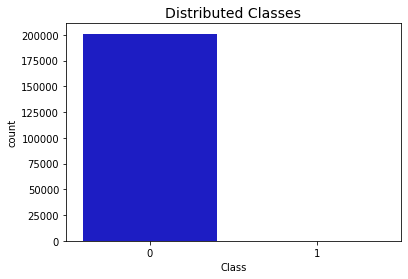

In [19]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts() / len(new_df))

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=new_df, palette=colors)
plt.title('Distributed Classes', fontsize=14)
plt.show()

In [20]:
# Kullanılacak özelliklerin listesi
features = new_df.columns[0:30]  # 'V1' ile 'V28' arası özellikler

for feature in features:
    fraud_values = new_df[feature].loc[new_df['Class'] == 1].values
    q25, q75 = np.percentile(fraud_values, 25), np.percentile(fraud_values, 75)
    iqr = q75 - q25

    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    
    print(f'{feature} Lower Bound: {lower_bound}')
    print(f'{feature} Upper Bound: {upper_bound}')
    
    outliers = [x for x in fraud_values if x < lower_bound or x > upper_bound]
    print(f'{feature} Outliers: {outliers}')
    print(f'Feature {feature} Outliers for Fraud Cases: {len(outliers)}')

    new_df = new_df.drop(new_df[(new_df[feature] > upper_bound) | (new_df[feature] < lower_bound)].index)
    print(f'Number of Instances after outliers removal for {feature}: {len(new_df)}')
    print('----' * 22)


scaled_amount Lower Bound: -0.689478096835045
scaled_amount Upper Bound: 0.3666247467337385
scaled_amount Outliers: [1.2088311325368548, 2.080905470551247, 2.1504925592119055, 1.5120519807168311, 0.8135261650248027, 2.293439530496751, 1.1736183888772445, 1.0885209250331866, 0.7676937050234053, 3.056941242227346, 1.0621113672884792, 1.2638859777824356, 1.469153916020401, 0.4103961433661706, 2.3071333752532666, 0.7809683504506393, 2.5469153916020404, 3.030811150702159, 3.116048347655977, 1.0175365052749248, 3.351778103821701, 1.4951442744358276, 2.8687207433801443, 2.7639209110598757, 1.4068329490672817, 3.0452036610074757, 0.641374973800042, 0.8230280164885071, 1.7134073918815065, 2.207783134213652, 0.8702578075875079, 0.6008523719695382, 1.8369314609096627, 1.0175365052749248, 1.7588206525536227]
Feature scaled_amount Outliers for Fraud Cases: 35
Number of Instances after outliers removal for scaled_amount: 144320
------------------------------------------------------------------------

In [21]:
# Dimensionality Reduction and Clustering:
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

  File "C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


T-SNE took 4.1e+02 s
PCA took 0.46 s
Truncated SVD took 0.39 s


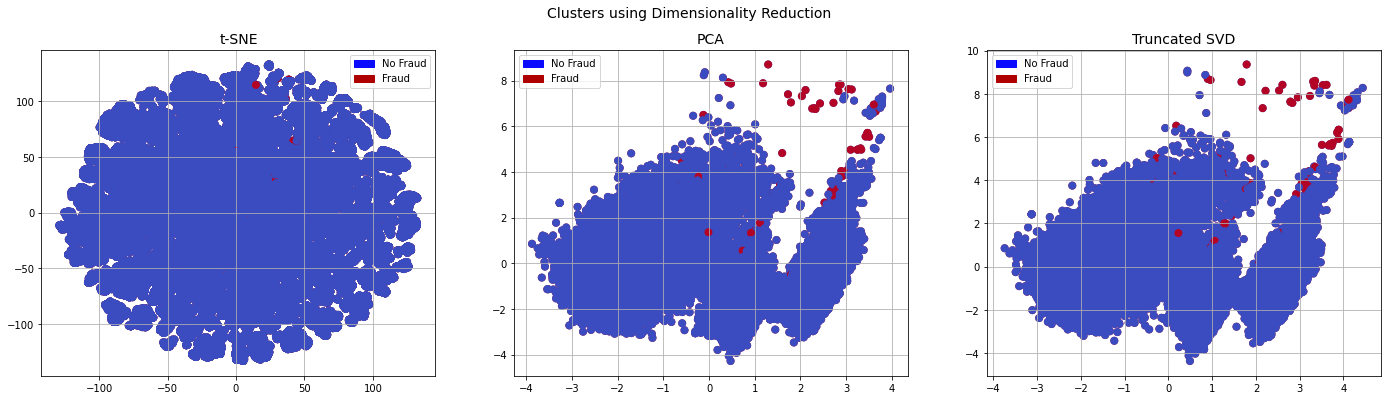

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [23]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [24]:
# Our data is already scaled we should split our training and test sets
# This is explicitly used for normal way data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [26]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GaussianNB": GaussianNB(),
    "GBClassifier": GradientBoostingClassifier()
}

In [27]:
# Wow our scores are getting even high scores even when applying cross validation.
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 6) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 99.9538 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 99.9587 % accuracy score
Classifiers:  SVC Has a training score of 99.9567 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 99.9282 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 99.9597 % accuracy score
Classifiers:  GaussianNB Has a training score of 98.9113 % accuracy score
Classifiers:  GradientBoostingClassifier Has a training score of 99.9233 % accuracy score


In [28]:
t0 = time.time()

# Use GridSearchCV to find the best parameters.

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2','elasticnet'],'tol':[3e-5,6e-5,1e-4,3e-4,6e-4], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :38.43539118766785 sec


In [29]:
t0 = time.time()

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :1041.5935344696045 sec


In [30]:
print(knears_neighbors)

KNeighborsClassifier(n_neighbors=2)


In [31]:
t0 = time.time()
# Support Vector Classifier best estimator
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :711.3842256069183 sec


In [32]:
print(grid_svc.best_estimator_)

SVC(C=1)


In [33]:
t0 = time.time()
# DecisionTree Classifier best estimator
tree_params = {"criterion": ["gini", "entropy"], "min_samples_leaf": list(range(2,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :214.6647515296936 sec


In [34]:
print(tree_clf)

DecisionTreeClassifier(min_samples_leaf=6)


In [35]:
t0 = time.time()
# Random Forest best estimator
rf_params = {"n_estimators":[50,100,150], "criterion": ["gini", "entropy","log_loss"]}

grid_rf = GridSearchCV(RandomForestClassifier(), rf_params)
grid_rf.fit(X_train, y_train)

# random forest best estimator
rf_clf = grid_rf.best_estimator_

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :2613.8716673851013 sec


In [36]:
print(rf_clf)

RandomForestClassifier()


In [37]:
t0 = time.time()
# Naive Bayes best estimator
nb_params = {"var_smoothing":[1e-10, 1e-9, 1e-8]}
grid_nb = GridSearchCV(GaussianNB(), nb_params)
grid_nb.fit(X_train, y_train)

# Gaussian NB best estimator
gaussian_nb = grid_nb.best_estimator_


t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :1.2990987300872803 sec


In [38]:
print(gaussian_nb)

GaussianNB(var_smoothing=1e-10)


In [39]:
t0 = time.time()

#GB best estimator
gb_params = {"loss": ["log_loss","exponential"]}

grid_gb = GridSearchCV(GradientBoostingClassifier(), gb_params)
grid_gb.fit(X_train, y_train)

# Gradient Boosting Classifier best estimator
gb_clf = grid_gb.best_estimator_

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :2352.730228662491 sec


In [40]:
print(gb_clf)

GradientBoostingClassifier(loss='exponential')


In [41]:
t0 = time.time()

# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 4).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 4).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 4).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 4).astype(str) + '%')

rf_score = cross_val_score(rf_clf, X_train, y_train, cv=5)
print('Random Forest Classifier Cross Validation Score', round(rf_score.mean() * 100, 4).astype(str) + '%')

nb_score = cross_val_score(gaussian_nb, X_train, y_train, cv=5)
print('Naive Bayes Cross Validation Score', round(nb_score.mean() * 100, 4).astype(str) + '%')

gb_score = cross_val_score(gb_clf, X_train, y_train, cv=5)
print('Gradient Boosting Cross Validation Score', round(nb_score.mean() * 100, 4).astype(str) + '%')

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Logistic Regression Cross Validation Score:  99.9538%
Knears Neighbors Cross Validation Score 99.9636%
Support Vector Classifier Cross Validation Score 99.9567%
DecisionTree Classifier Cross Validation Score 99.9508%
Random Forest Classifier Cross Validation Score 99.9597%
Naive Bayes Cross Validation Score 98.9113%
Gradient Boosting Cross Validation Score 98.9113%
Fitting oversample data took :1322.6225137710571 sec


In [42]:
t0 = time.time()

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

accuracy = []
precision = []
recall = []
f1 = []
auc = []

# Implementing NearMiss Technique
# Distribution of NearMiss (Just to see how it distributes the labels, we won't use these variables)
nm = NearMiss(sampling_strategy='majority')
X_nearmiss, y_nearmiss = nm.fit_resample(X.values, y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way
for train, test in sss.split(Xtrain, ytrain):
    pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    model = pipeline.fit(Xtrain.iloc[train], ytrain.iloc[train])
    prediction = model.predict(Xtrain.iloc[test])
    
    accuracy.append(pipeline.score(Xtrain.iloc[test], ytrain.iloc[test]))
    precision.append(precision_score(ytrain.iloc[test], prediction))
    recall.append(recall_score(ytrain.iloc[test], prediction))
    f1.append(f1_score(ytrain.iloc[test], prediction))
    auc.append(roc_auc_score(ytrain.iloc[test], prediction))

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

NearMiss Label Distribution: Counter({0: 492, 1: 492})
Fitting oversample data took :2.932509660720825 sec


In [43]:
t0 = time.time()

# Let's Plot LogisticRegression Learning Curve
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :0.0019989013671875 sec


Fitting oversample data took :2514.4661276340485 sec


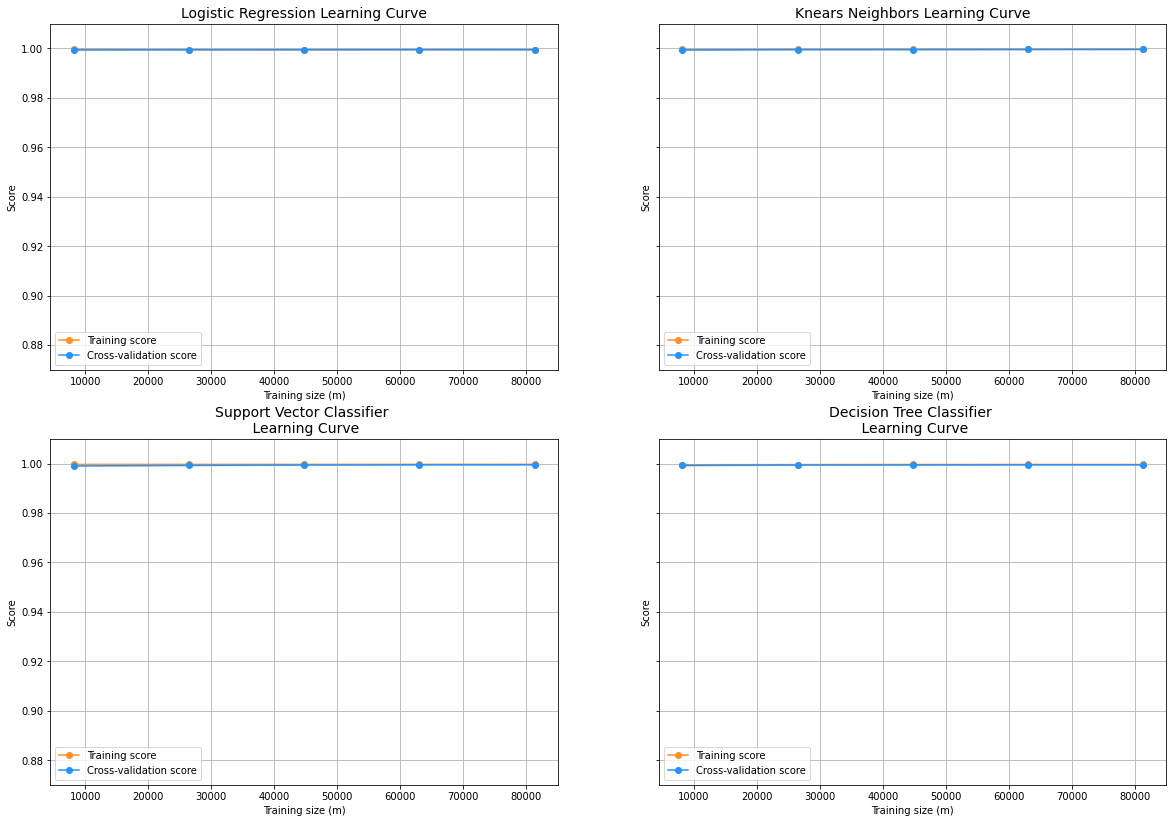

In [44]:
t0 = time.time()

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

In [46]:
t0 = time.time()


# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)


rf_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5)

nb_pred = cross_val_predict(gaussian_nb, X_train, y_train, cv=5)

gb_pred = cross_val_predict(gb_clf, X_train, y_train, cv=5)


print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, rf_pred))
print('Naive Bayes Classifier: ', roc_auc_score(y_train, nb_pred))
print('Gradient Boosting Classifier: ', roc_auc_score(y_train, gb_pred))


t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Logistic Regression:  0.9633629651506201
KNears Neighbors:  0.8349803110848592
Support Vector Classifier:  0.9142049616066155
Decision Tree Classifier:  0.7849606221697183
Random Forest Classifier:  0.8249753888560739
Naive Bayes Classifier:  0.8846593817680646
Gradient Boosting Classifier:  0.8099655443985037
Fitting oversample data took :1253.8780148029327 sec


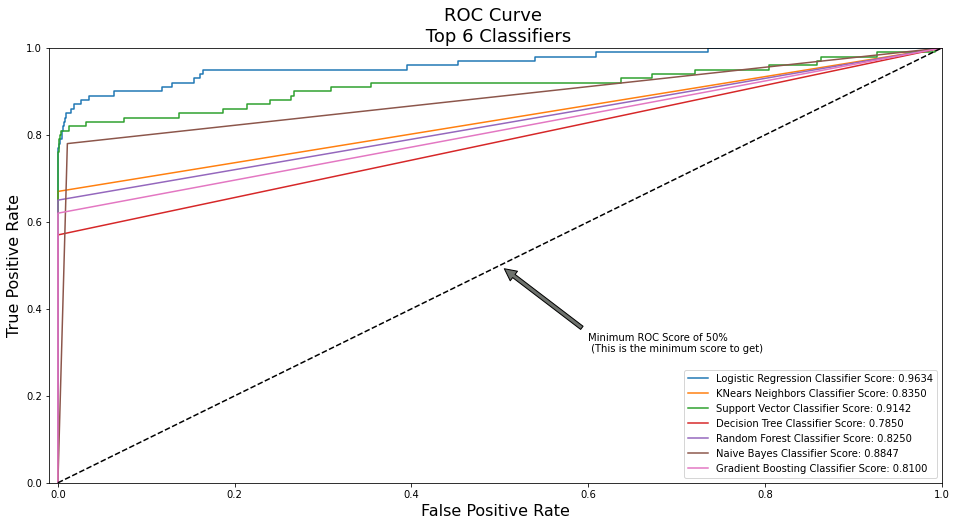

Fitting oversample data took :0.44979357719421387 sec


In [47]:
t0 = time.time()


log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
rf_fpr, rf_tpr, rf_threshold = roc_curve(y_train, rf_pred)
nb_fpr, nb_tpr, nb_threshold = roc_curve(y_train, nb_pred)
gb_fpr, gb_tpr, gb_threhsold = roc_curve(y_train,gb_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr,rf_fpr, rf_tpr,nb_fpr, nb_tpr,gb_fpr, gb_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 6 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(rf_fpr, rf_tpr, label = 'Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    plt.plot(nb_fpr, nb_tpr, label = 'Naive Bayes Classifier Score: {:.4f}'.format(roc_auc_score(y_train, nb_pred)))
    plt.plot(gb_fpr, gb_tpr, label = 'Gradient Boosting Classifier Score: {:.4f}'.format(roc_auc_score(y_train, gb_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr,rf_fpr, rf_tpr,nb_fpr, nb_tpr,gb_fpr, gb_tpr)
plt.show()

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

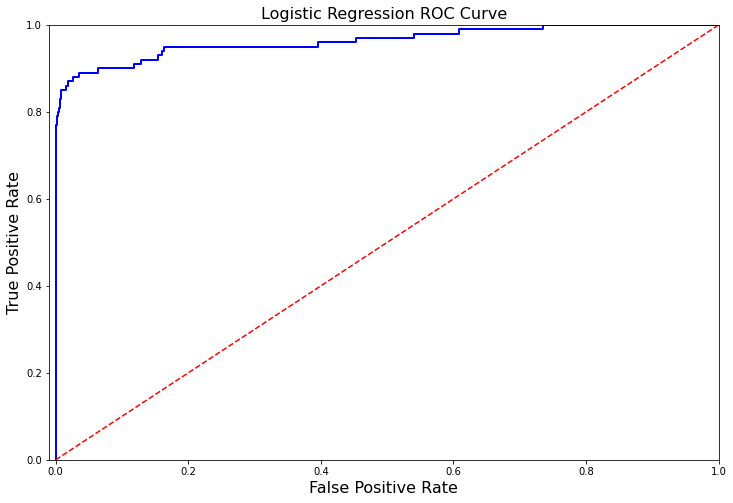

In [48]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

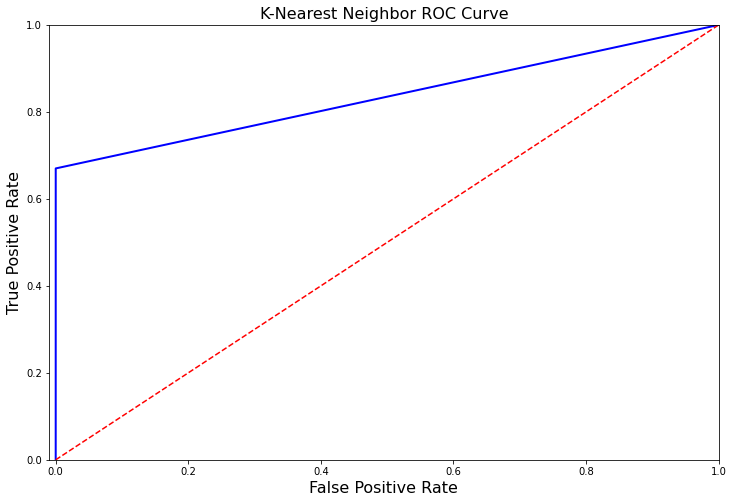

In [49]:
def knears_roc_curve(knear_fpr, knear_tpr):
    plt.figure(figsize=(12,8))
    plt.title('K-Nearest Neighbor ROC Curve', fontsize=16)
    plt.plot(knear_fpr, knear_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

knears_roc_curve(knear_fpr, knear_tpr)
plt.show()

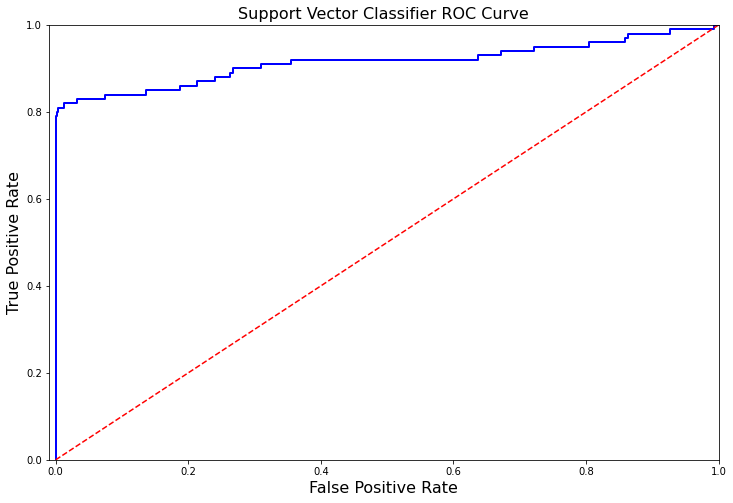

In [50]:
def svc_roc_curve(svc_fpr, svc_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Support Vector Classifier ROC Curve', fontsize=16)
    plt.plot(svc_fpr, svc_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

svc_roc_curve(svc_fpr, svc_tpr)
plt.show()

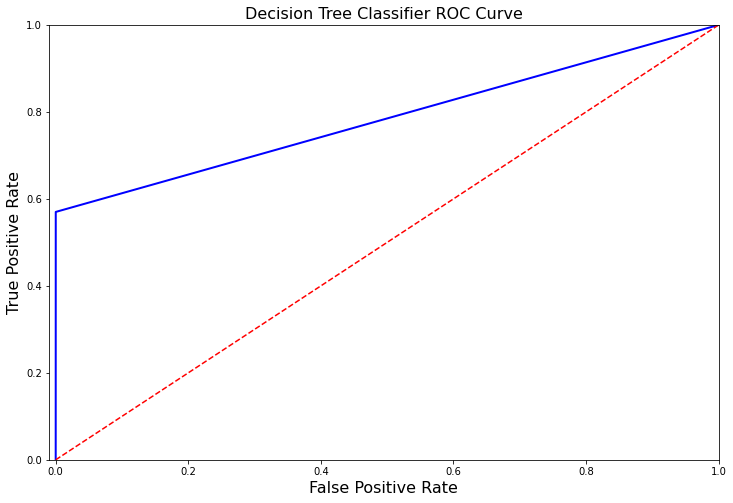

In [51]:
def dt_roc_curve(tree_fpr, tree_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Decision Tree Classifier ROC Curve', fontsize=16)
    plt.plot(tree_fpr, tree_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

dt_roc_curve(tree_fpr, tree_tpr)
plt.show()

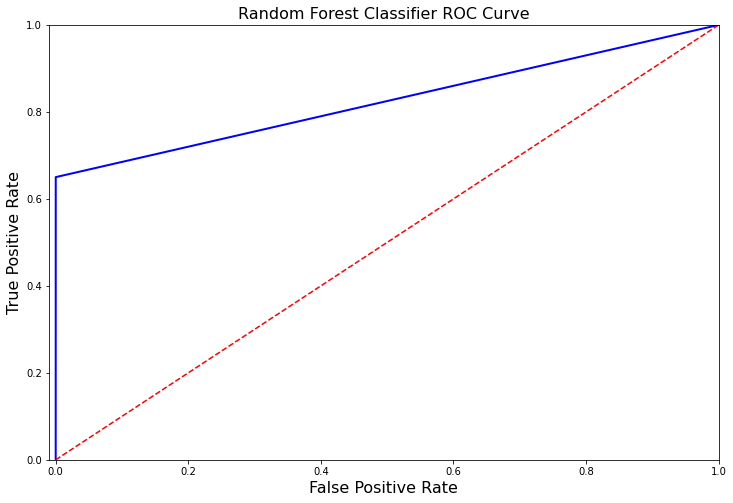

In [52]:
def rf_roc_curve(rf_fpr, rf_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Random Forest Classifier ROC Curve', fontsize=16)
    plt.plot(rf_fpr, rf_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

rf_roc_curve(rf_fpr, rf_tpr)
plt.show()

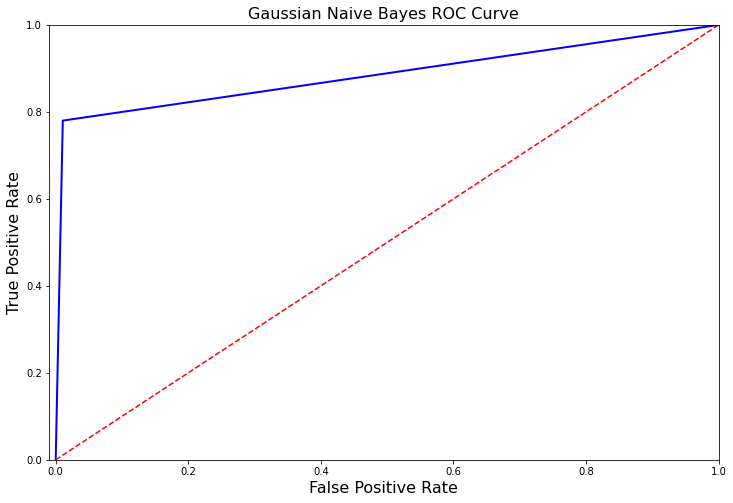

In [53]:
def nb_roc_curve(nb_fpr, nb_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Gaussian Naive Bayes ROC Curve', fontsize=16)
    plt.plot(nb_fpr, nb_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

nb_roc_curve(nb_fpr, nb_tpr)
plt.show()

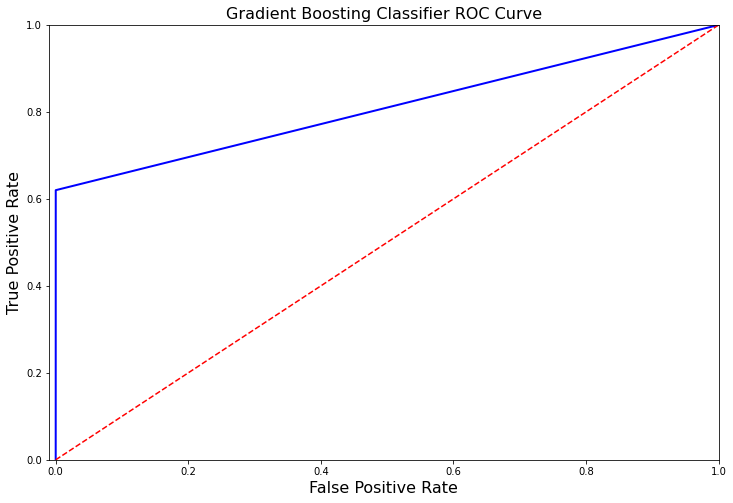

In [54]:
def gb_roc_curve(gb_fpr, gb_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Gradient Boosting Classifier ROC Curve', fontsize=16)
    plt.plot(gb_fpr, gb_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

gb_roc_curve(gb_fpr, gb_tpr)
plt.show()

In [55]:
t0 = time.time()

precision_logreg, recall_logreg, threshold_logreg = precision_recall_curve(y_train, knears_pred)

y_pred_logreg = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_logreg)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_logreg)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_logreg)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_logreg)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.84
Precision Score: 0.00
F1 Score: 0.01
Accuracy Score: 0.81
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :0.07994341850280762 sec


In [56]:
t0 = time.time()

precision_knears, recall_knears, threshold_knears = precision_recall_curve(y_train, knears_pred)

y_pred_knears = knears_neighbors.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_knears)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_knears)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_knears)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_knears)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.73
Precision Score: 1.00
F1 Score: 0.84
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :9.876616477966309 sec


In [57]:
t0 = time.time()

precision_svc, recall_svc, threshold_svc = precision_recall_curve(y_train, svc_pred)

y_pred_svc = svc.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_svc)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_svc)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_svc)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_svc)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.70
Precision Score: 0.99
F1 Score: 0.82
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :5.092224597930908 sec


In [58]:
t0 = time.time()

precision_tree, recall_tree, threshold_tree = precision_recall_curve(y_train, tree_pred)

y_pred_tree = tree_clf.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_tree)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_tree)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_tree)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_tree)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.65
Precision Score: 0.96
F1 Score: 0.77
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :0.0720069408416748 sec


In [59]:
t0 = time.time()

precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train, rf_pred)

y_pred_rf = rf_clf.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_rf)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_rf)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_rf)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_rf)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 1.00
Precision Score: 1.00
F1 Score: 1.00
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :0.6374170780181885 sec


In [60]:
t0 = time.time()

precision_nb, recall_nb, threshold_nb = precision_recall_curve(y_train, nb_pred)

y_pred_nb = gaussian_nb.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_nb)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_nb)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_nb)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_nb)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.77
Precision Score: 0.06
F1 Score: 0.12
Accuracy Score: 0.99
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :0.12481021881103516 sec


In [61]:
t0 = time.time()

precision_gb, recall_gb, threshold_gb = precision_recall_curve(y_train, gb_pred)

y_pred_gb = gb_clf.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred_gb)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred_gb)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred_gb)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred_gb)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(accuracy)))
print("Precision Score: {:.2f}".format(np.mean(precision)))
print("Recall Score: {:.2f}".format(np.mean(recall)))
print("F1 Score: {:.2f}".format(np.mean(f1)))
print('---' * 45)

t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.73
Precision Score: 0.97
F1 Score: 0.83
Accuracy Score: 1.00
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.57
Precision Score: 0.00
Recall Score: 0.95
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------
Fitting oversample data took :0.13885092735290527 sec


### burada komple karşılaştırma öncesi hepsini yazdıralım


In [62]:
t0 = time.time()

precision_logreg, recall_logreg, threshold_logreg = precision_recall_curve(y_train, knears_pred)

y_pred_logreg = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Logistic Regression Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_logreg)))
print('Logistic Regression Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_logreg)))
print('Logistic Regression F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_logreg)))
print('Logistic Regression Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_logreg)))
print('---' * 45)


precision_knears, recall_knears, threshold_knears = precision_recall_curve(y_train, knears_pred)

y_pred_knears = knears_neighbors.predict(X_train)

# Overfitting Case
print('---' * 45)
print('K-Near Neigbors Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_knears)))
print('K-Near Neigbors Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_knears)))
print('K-Near Neigbors F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_knears)))
print('K-Near Neigbors Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_knears)))
print('---' * 45)

precision_svc, recall_svc, threshold_svc = precision_recall_curve(y_train, svc_pred)

y_pred_svc = svc.predict(X_train)

# Overfitting Case
print('---' * 45)
print('SVM Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_svc)))
print('SVM Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_svc)))
print('SVM F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_svc)))
print('SVM Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_svc)))
print('---' * 45)


precision_tree, recall_tree, threshold_tree = precision_recall_curve(y_train, tree_pred)

y_pred_tree = tree_clf.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Decision Tree Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_tree)))
print('Decision Tree Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_tree)))
print('Decision Tree F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_tree)))
print('Decision Tree Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_tree)))
print('---' * 45)


precision_rf, recall_rf, threshold_rf = precision_recall_curve(y_train, rf_pred)

y_pred_rf = rf_clf.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Random Forest Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_rf)))
print('Random Forest Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_rf)))
print('Random Forest F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_rf)))
print('Random Forest Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_rf)))
print('---' * 45)


precision_nb, recall_nb, threshold_nb = precision_recall_curve(y_train, nb_pred)

y_pred_nb = gaussian_nb.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Gaussian Naive Bayes Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_nb)))
print('Gaussian Naive Bayes Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_nb)))
print('Gaussian Naive Bayes F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_nb)))
print('Gaussian Naive Bayes Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_nb)))
print('---' * 45)


precision_gb, recall_gb, threshold_gb = precision_recall_curve(y_train, gb_pred)

y_pred_gb = gb_clf.predict(X_train)

print('---' * 45)
print('Gradient Boosting Recall Score: {:.4f}'.format(recall_score(y_train, y_pred_gb)))
print('Gradient Boosting Precision Score: {:.4f}'.format(precision_score(y_train, y_pred_gb)))
print('Gradient Boosting F1 Score: {:.4f}'.format(f1_score(y_train, y_pred_gb)))
print('Gradient Boosting Accuracy Score: {:.4f}'.format(accuracy_score(y_train, y_pred_gb)))
print('---' * 45)


# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.4f}".format(np.mean(accuracy)))
print("Precision Score: {:.4f}".format(np.mean(precision)))
print("Recall Score: {:.4f}".format(np.mean(recall)))
print("F1 Score: {:.4f}".format(np.mean(f1)))
print('---' * 45)


t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

---------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression Recall Score: 0.8400
Logistic Regression Precision Score: 0.0044
Logistic Regression F1 Score: 0.0087
Logistic Regression Accuracy Score: 0.8127
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
K-Near Neigbors Recall Score: 0.7300
K-Near Neigbors Precision Score: 1.0000
K-Near Neigbors F1 Score: 0.8439
K-Near Neigbors Accuracy Score: 0.9997
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
SVM Re

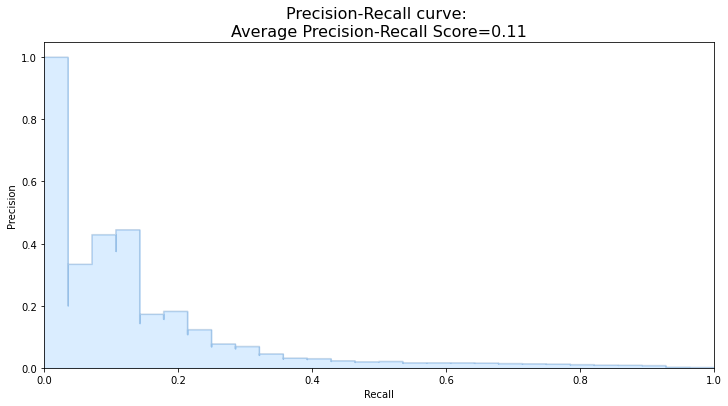

In [66]:
from sklearn.metrics import average_precision_score

# Modelinizin tahmin puanlarını oluşturun (örneğin predict_proba'dan gelen puanlar)
y_score = model.predict_proba(X_test)[:, 1]

# Gerçek test etiketleri ile ortalama hassasiyet-recall skorunu hesaplayın
average_precision = average_precision_score(y_test, y_score)

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: \nAverage Precision-Recall Score={0:0.2f}'.format(
          average_precision), fontsize=16)
plt.show()


# SMOTE Tekniği kullanarak Oversampling işlemi yapalım ve denememizi gerçekleştirelim.

In [78]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# Veri bölme
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(features, labels, test_size=0.2, random_state=42)

# StratifiedKFold
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []


log_reg_params = {"penalty": ['l2', 'none'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(solver='lbfgs'), log_reg_params, n_iter=4)

for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = rand_log_reg.fit(X_resampled, y_resampled)
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)


---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9794
Precision: 0.0722
Recall: 0.9188
F1: 0.1339
---------------------------------------------------------------------------------------------------------------------------------------


In [77]:
knears_params = {"n_neighbors": list(range(2, 5, 1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# KNeighborsClassifier modeli ve SMOTE dengeli örnekleme
knn = KNeighborsClassifier()
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = knn.fit(X_resampled, y_resampled)
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9980
Precision: 0.4676
Recall: 0.8706
F1: 0.6076
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
#şu anlık çalıştırma
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# SVM modeli ve SMOTE dengeli örnekleme
svc = SVC()
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = svc.fit(X_resampled, y_resampled)
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)

In [82]:
reduced_df = df.sample(frac=0.1, random_state=42)
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# GridSearchCV ile belirlenmiş SVC modeli ve SMOTE dengeli örnekleme
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = grid_svc.best_estimator_.fit(X_resampled, y_resampled)  
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)


---------------------------------------------------------------------------------------------------------------------------------------

Accuracy: 0.9848
Precision: 0.0934
Recall: 0.8782
F1: 0.1686
---------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
reduced_df = df.sample(frac=0.1, random_state=42)
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# GridSearchCV ile belirlenmiş DecisionTree modeli ve SMOTE dengeli örnekleme
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = grid_tree.best_estimator_.fit(X_resampled, y_resampled)  # grid_tree.best_estimator_ kullanıldı
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)


In [ ]:
reduced_df = df.sample(frac=0.1, random_state=42)
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# GridSearchCV ile belirlenmiş DecisionTree modeli ve SMOTE dengeli örnekleme
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = grid_tree.best_estimator_.fit(X_resampled, y_resampled)  # grid_tree.best_estimator_ kullanıldı
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)

In [ ]:
reduced_df = df.sample(frac=0.1, random_state=42)
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# GridSearchCV ile belirlenmiş Naive Bayes modeli ve SMOTE dengeli örnekleme
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = grid_nb.best_estimator_.fit(X_resampled, y_resampled)  # grid_nb.best_estimator_ kullanıldı
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}"


In [ ]:
reduced_df = df.sample(frac=0.1, random_state=42)
sss = StratifiedKFold(n_splits=5, shuffle=True)

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# GridSearchCV ile belirlenmiş GradientBoosting modeli ve SMOTE dengeli örnekleme
for train_index, test_index in sss.split(original_Xtrain, original_ytrain):
    smote = SMOTE(sampling_strategy='minority')
    X_resampled, y_resampled = smote.fit_resample(original_Xtrain[train_index], original_ytrain[train_index])
    model = grid_gb.best_estimator_.fit(X_resampled, y_resampled)  # grid_gb.best_estimator_ kullanıldı
    prediction = model.predict(original_Xtrain[test_index])

    accuracy_lst.append(np.mean(prediction == original_ytrain[test_index]))
    precision_lst.append(precision_score(original_ytrain[test_index], prediction))
    recall_lst.append(recall_score(original_ytrain[test_index], prediction))
    f1_lst.append(f1_score(original_ytrain[test_index], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test_index], prediction))

print('---' * 45)
print('')
print("Accuracy: {:.4f}".format(np.mean(accuracy_lst)))
print("Precision: {:.4f}".format(np.mean(precision_lst)))
print("Recall: {:.4f}".format(np.mean(recall_lst)))
print("F1: {:.4f}".format(np.mean(f1_lst)))
print('---' * 45)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math



In [ ]:

labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

In [ ]:
y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))


In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [ ]:

# Use the `sampling_strategy` parameter instead of `ratio`
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)


# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

In [ ]:
# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [ ]:
# RandomForest Classifier ile confusion matrix hesaplama
y_pred_rf = rf_clf.predict(X_test)
rf_cf = confusion_matrix(y_test, y_pred_rf)



In [ ]:
# GaussianNB (Naive Bayes) ile confusion matrix hesaplama
y_pred_nb = gaussian_nb.predict(X_test)
nb_cf = confusion_matrix(y_test, y_pred_nb)


In [ ]:
# Gradient Boosting Classifier ile confusion matrix hesaplama
y_pred_gb = gb_clf.predict(X_test)
gb_cf = confusion_matrix(y_test, y_pred_gb)


In [ ]:
# Define confusion matrices for other models
confusion_matrices = [
    (kneighbors_cf, "KNearsNeighbors"),
    (svc_cf, "Support Vector Classifier"),
    (tree_cf, "DecisionTree Classifier"),
    (rf_cf, "RandomForest Classifier"),
    (nb_cf, "GaussianNB"),
    (gb_cf, "GradientBoosting Classifier"),
]

# Plot confusion matrices
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for ax, (matrix, model_name) in zip(axes.flatten(), confusion_matrices):
    sns.heatmap(matrix, annot=True, cmap=plt.cm.copper, fmt='g', ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()


In [ ]:
print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

print('Random Forest Classifier:')
print(classification_report(y_test, y_pred_rf))

print('Gaussian Naive Bayes Classifier:')
print(classification_report(y_test, y_pred_nb))

print('Gradient Boosting Classifier:')
print(classification_report(y_test, y_pred_gb))

In [ ]:
# Final Score in the test set of logistic regression
# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Scaled Normal Data', 'SMOTE technique data'], 'Score': [score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

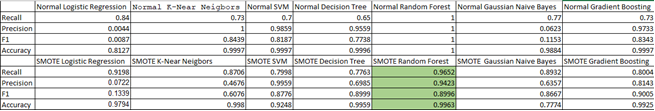